# DUTCH Fastshap vs FastShap with DP

In [106]:
import shap  # https://github.com/slundberg/shap
import shapreg  # https://github.com/iancovert/shapley-regression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import torch

# import from parent level
import sys
import copy

sys.path.append("../")
from fastshap import FastSHAP
from scipy.stats import sem
from fastshap.utils import MaskLayer1d
import torch.nn as nn
from fastshap import Surrogate, KLDivLoss
from scipy.stats import spearmanr
import shap  # https://github.com/slundberg/shap
import shapreg  # https://github.com/iancovert/shapley-regression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import torch
from fastshap import FastSHAP
from scipy.stats import sem
from fastshap.utils import MaskLayer1d
import torch.nn as nn
import torch.nn.functional as F
from fastshap import Surrogate, KLDivLoss
from aix360.metrics.local_metrics import faithfulness_metric
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
import sys

sys.path.append("../")
from Utils.utils import Utils
from Client.client_explainer import prepare_dataset_for_explainer_FL

from metrics import agreement_fraction, pairwise_rank_agreement, rankcorr

import os
import torch
import torch.nn as nn
from fastshap.surrogate_dp import SurrogateDP

import sys

sys.path.append("../")
from pathlib import Path
from fastshap.fastshap_dp import (
    FastSHAP,
    calculate_grand_coalition_FL,
    validate_FL,
)

import warnings

# ignore warnings
warnings.filterwarnings("ignore")

### Functions

In [107]:
import dill

In [108]:
def prepare_data_FL(
    test_clients,
    batch_size,
    dataset_name,
    num_workers,
    fed_dir,
    device,
    num_features,
    surrogate,
    seed=42,
    train_clients=None,
):
    samples, targets = [], []
    for client in test_clients:
        data = Utils.get_dataset(
            path_to_data=Path(fed_dir),
            cid=client,
            dataset=dataset_name,
            partition="train",
        )
        for item in data:
            X, _, y = item
            samples.append(X)
            targets.append(y)
    dill.dump(samples, open("samples_test.pkl", "wb"))
    dill.dump(targets, open("targets_test.pkl", "wb"))

    if train_clients:
        max_dataset = 0
        min_dataset = 100000
        delta = 0
        samples_train, targets_train = [], []
        for client in train_clients:
            data = Utils.get_dataset(
                path_to_data=Path(fed_dir),
                cid=client,
                dataset=dataset_name,
                partition="train",
            )
            for item in data:
                X, _, y = item
                samples_train.append(X)
                targets_train.append(y)
            max_dataset = max(max_dataset, len(data))
            min_dataset = min(min_dataset, len(data))
            delta = max(delta, 1/len(data))
        print(max_dataset)
        print(min_dataset)
        print(delta)
        dill.dump(samples_train, open("samples_train.pkl", "wb"))
        dill.dump(targets_train, open("targets_train.pkl", "wb"))
    return samples, targets

In [109]:
# Faithfulness evaluation
class aix_model:
    def __init__(self, model):
        self.model = model

    def predict(self, x):
        x = torch.Tensor(x)
        return self.model(x).argmax(dim=1)

    def predict_proba(self, x):
        # since the activation function of the last layer is LogSoftmax
        # we need to apply the exponential to the output of the model
        # cast x to be a Tensor
        x = torch.Tensor(x)
        return torch.nn.functional.softmax(self.model(x)).detach().numpy()


def compute_faithfulness(x, y, fastshap_explanation, model, base_value):
    x = x[0]
    fastshap_explanation = np.array(torch.tensor(fastshap_explanation).cpu())

    faithfulness = faithfulness_metric(
        model=model,
        x=np.array(x),
        coefs=fastshap_explanation,
        base=base_value * np.ones(shape=fastshap_explanation.shape[0]),
    )
    return faithfulness


def process_explainer(
    explanation_file_name, explainer, model, x, y, index, base_value, base_path
):
    if not os.path.isfile(
        f"{base_path}/explanations/{explanation_file_name}_{index}.pt"
    ):
        fastshap_explanation = explainer.shap_values(x)[0][:, y]
        torch.save(
            fastshap_explanation,
            f"{base_path}/explanations/{explanation_file_name}_{index}.pt",
        )
    else:
        fastshap_explanation = torch.load(
            f"{base_path}/explanations/{explanation_file_name}_{index}.pt"
        )

    if not os.path.isfile(
        f"{base_path}/faithfulness/{explanation_file_name}_{index}_{base_value}.pt"
    ):
        faithfulness = compute_faithfulness(
            x,
            y,
            fastshap_explanation,
            model,
            base_value=base_value,
        )
        torch.save(
            faithfulness,
            f"{base_path}/faithfulness/{explanation_file_name}_{index}_{base_value}.pt",
        )
    else:
        faithfulness = torch.load(
            f"{base_path}/faithfulness/{explanation_file_name}_{index}_{base_value}.pt"
        )
    return fastshap_explanation, faithfulness

In [110]:
class Args:
    def __init__(self):
        self.dataset_name = "adult"
        self.sweep = True


class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [111]:
def plot_faithfulness_std_dev(
    faithfulness_no_dp,
    faithfulness_eps_05,
    faithfulness_eps_1,
    faithfulness_eps_2,
    faithfulness_eps_3,
    faithfulness_eps_4,
    faithfulness_eps_5,
    faithfulness_eps_10,
    faithfulness_eps_100,
):
    mean_no_dp = np.mean(faithfulness_no_dp)
    std_no_dp = np.std(faithfulness_no_dp)

    mean_eps_05 = np.mean(faithfulness_eps_05)
    std_eps_05 = np.std(faithfulness_eps_05)

    mean_eps_1 = np.mean(faithfulness_eps_1)
    std_eps_1 = np.std(faithfulness_eps_1)

    mean_eps_2 = np.mean(faithfulness_eps_2)
    std_eps_2 = np.std(faithfulness_eps_2)

    mean_eps_3 = np.mean(faithfulness_eps_3)
    std_eps_3 = np.std(faithfulness_eps_3)

    mean_eps_4 = np.mean(faithfulness_eps_4)
    std_eps_4 = np.std(faithfulness_eps_4)

    mean_eps_5 = np.mean(faithfulness_eps_5)
    std_eps_5 = np.std(faithfulness_eps_5)

    mean_eps_10 = np.mean(faithfulness_eps_10)
    std_eps_10 = np.std(faithfulness_eps_10)

    mean_eps_100 = np.mean(faithfulness_eps_100)
    std_eps_100 = np.std(faithfulness_eps_100)

    results_mean = {
        "No DP": [mean_no_dp],
        "Eps. 05": [mean_eps_05],
        "Eps. 1": [mean_eps_1],
        "Eps. 2": [mean_eps_2],
        "Eps. 3": [mean_eps_3],
        "Eps. 4": [mean_eps_4],
        "Eps. 5": [mean_eps_5],
        "Eps. 10": [mean_eps_10],
        "Eps. 100": [mean_eps_100],
    }

    results_std = {
        "No DP": [std_no_dp],
        "Eps. 05": [std_eps_05],
        "Eps. 1": [std_eps_1],
        "Eps. 2": [std_eps_2],
        "Eps. 3": [std_eps_3],
        "Eps. 4": [std_eps_4],
        "Eps. 5": [std_eps_5],
        "Eps. 10": [std_eps_10],
        "Eps. 100": [std_eps_100],
    }

    # Extracting the means and standard errors

    labels = list(results_mean.keys())
    means = [results_mean[label][0] for label in labels]
    errors = [results_std[label][0] for label in labels]

    # Plotting
    plt.figure(figsize=(8, 6))

    # Use different markers for each point
    markers = ["o", "s", "^", "D", "P", "X", "H", "v", "<", ">", "d", "p", "*", "h"]

    for i, label in enumerate(labels):
        plt.errorbar(
            i,
            means[i],
            yerr=errors[i],
            fmt=markers[i],
            label=label,
            capsize=5,
            markersize=10,
        )

    # Customizing the plot
    plt.xticks(range(len(labels)), labels, fontsize=12)
    plt.ylabel("Mean Faithfulness", fontsize=14)
    plt.title(
        "Mean Faithfulness with Standard Deviation for Different Epsilon Values",
        fontsize=16,
    )
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()

    # orientation x axis labels
    plt.xticks(rotation=90)

    plt.show()


def plot_error_bar(
    labels,
    results_mean,
    y_label,
    title,
    y_lim=None,
    x_ticks=None,
    results_std=None,
):
    errors = None
    means = [results_mean[label] for label in labels]
    if results_std:
        errors = [results_std[label] for label in labels]

    # Plotting
    plt.figure(figsize=(8, 6))

    # Use different markers for each point
    markers = ["o", "s", "^", "D", "P", "X", "H", "v", "<", ">", "d", "p", "*", "h"]

    if errors:
        for i, label in enumerate(labels):
            plt.errorbar(
                i,
                means[i],
                yerr=errors[i],
                fmt=markers[i],
                label=label,
                capsize=5,
                markersize=10,
            )
    else:
        for i, label in enumerate(labels):
            plt.errorbar(
                i,
                means[i],
                fmt=markers[i],
                label=label,
                capsize=5,
                markersize=10,
            )

    # Customizing the plot
    plt.xticks(range(len(labels)), labels, fontsize=12)
    plt.ylabel(y_label, fontsize=14)
    plt.title(
        title,
        fontsize=16,
    )
    # y lim
    if y_lim:
        plt.ylim(y_lim)
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.xticks(rotation=90)

    # Chnge the labels of the x axis
    if x_ticks:
        plt.xticks(range(len(labels)), x_ticks, fontsize=12)
    else:
        plt.xticks(range(len(labels)), labels, fontsize=12)

    plt.show()

In [112]:
def load_data(
    private_model: bool,
    private_surrogate: bool,
    explainer_privacy_levels: list,
    base_path: str,
    model_name: str,
    surrogate_name: str,
    explainer_name: str,
    device: str,
    num_features: int,
    eps_bb: str = "",
):
    loaded_data = {}
    loaded_data["private_model"] = private_model
    loaded_data["private_surrogate"] = private_surrogate
    private_model_str = "private_model_" if private_model else ""

    if os.path.isfile(
        f"{base_path}bb/{model_name}"
        + ("_NO_DP" if not private_model else f"_{eps_bb}")
        + ".pth"
    ):
        print("Loading saved model")
        model = torch.load(
            f"{base_path}bb/{model_name}"
            + ("_NO_DP" if not private_model else f"_{eps_bb}")
            + ".pth"
        ).to("cpu")
        model_aix = aix_model(model)
    else:
        print(
            f"Model not found: {base_path}bb/{model_name}"
            + ("_NO_DP" if not private_model else f"_{eps_bb}")
            + ".pth"
        )

    # Surrogate model without DP
    if os.path.isfile(
        f"{base_path}/surrogate/{surrogate_name}"
        + ("_NO_DP" if not private_model else f"_{eps_bb}")
        + ".pth"
    ):
        print("Loading saved surrogate model")
        surr = torch.load(
            f"{base_path}/surrogate/{surrogate_name}"
            + ("_NO_DP" if not private_model else f"_{eps_bb}")
            + ".pth"
        ).to(device)
        surrogate = Surrogate(surr, num_features)
    else:
        print(
            f"Surrogate model not found: {base_path}/surrogate/{surrogate_name}"
            + ("_NO_DP" if not private_model else f"_{eps_bb}")
            + ".pth"
        )

    loaded_data["model"] = model
    loaded_data["model_aix"] = model_aix
    loaded_data["surrogate"] = surrogate

    for eps in explainer_privacy_levels:
        # DP 0.5
        if os.path.isfile(f"{base_path}/explainer/{explainer_name}_{eps}.pth"):
            print("Loading saved explainer model")
            explainer = torch.load(
                f"{base_path}/explainer/{explainer_name}_{eps}.pth"
            ).to(device)
            fastshap = FastSHAP(
                explainer,
                surrogate,
                normalization="none",
                link=nn.Softmax(dim=-1),
                num_features=num_features,
            )
            loaded_data[f"explainer_{eps}"] = fastshap
        else:
            print(
                f"Explainer model not found: {base_path}/explainer/{explainer_name}_{private_model_str}{eps}.pth"
            )
    return loaded_data

In [113]:
def get_explanations(
    model_predictions: list,
    X_test,
    loaded_data: dict,
    base_value: float,
    base_path: str,
    explainer_privacy_levels: list,
):
    for privacy_level in explainer_privacy_levels:
        faithfulness = []
        explanations = []
        for index, (x, y) in enumerate(zip(X_test, model_predictions)):
            y = 0 if not y else 1
            x = np.array([list(x)])

            shap_NO_DP, faithfulness_NO_DP = process_explainer(
                f"private_model_{loaded_data['private_model']}_surrogate_{loaded_data['private_surrogate']}_explainer_{privacy_level}",
                loaded_data[f"explainer_{privacy_level}"],
                loaded_data["model_aix"],
                x,
                y,
                index,
                base_value,
                base_path=base_path,
            )
            explanations.append(copy.deepcopy(shap_NO_DP))
            faithfulness.append(faithfulness_NO_DP)
            loaded_data[f"explanations_{privacy_level}"] = explanations
            loaded_data[f"faithfulness_{privacy_level}"] = faithfulness

In [114]:
def plot_base_explainer_shap_values(
    loaded_data, explainer_privacy_levels, X_test, feature_names, title, explainer_name
):
    explanations = []
    for index in range(len(X_test)):
        fastshap_NO_DP = loaded_data[explainer_name][index]
        # compute the absolute values of the shap values
        fastshap_NO_DP = np.abs(fastshap_NO_DP)
        explanations.append(fastshap_NO_DP)

    # mean of the absolute values of the shap values
    mean_explanations = np.mean(explanations, axis=0)
    # sort the mean_explanations and the corresponding feature names
    sorted_indices = np.argsort(mean_explanations)[::-1]
    print(len(sorted_indices))
    print(len(feature_names))
    # plot the mean shap values with the corresponding feature names in sorted indices
    plt.figure(figsize=(10, 6))
    plt.bar(
        [feature_names[i] for i in sorted_indices], mean_explanations[sorted_indices]
    )
    plt.xticks(rotation=90)
    plt.xlabel("Features")
    plt.ylabel("Mean SHAP Value")
    plt.title(title)
    plt.show()

In [165]:
def plot_base_explainer_shap_values_comparison(
    loaded_data, explainer_names, X_test, feature_names, title, file_name
):
    explanations_1 = []
    explanations_2 = []

    for index in range(len(X_test)):
        fastshap_1 = loaded_data[explainer_names[0]][index]
        fastshap_2 = loaded_data[explainer_names[1]][index]

        # compute the absolute values of the shap values
        fastshap_1 = np.abs(fastshap_1)
        fastshap_2 = np.abs(fastshap_2)

        explanations_1.append(fastshap_1)
        explanations_2.append(fastshap_2)

    # mean of the absolute values of the shap values
    mean_explanations_1 = np.mean(explanations_1, axis=0)
    mean_explanations_2 = np.mean(explanations_2, axis=0)

    # sort the mean_explanations and the corresponding feature names
    sorted_indices = np.argsort(mean_explanations_1)[::-1]

    # plot the mean shap values with the corresponding feature names in sorted indices
    plt.figure(figsize=(10, 6))

    # Remove the "bias" feature from the feature names

    bar_width = 0.35

    # remove "bias" from mean_explanations_1, mean_explanations_2 and feature_names
    mean_explanations_1 = mean_explanations_1[sorted_indices]
    mean_explanations_2 = mean_explanations_2[sorted_indices]
    feature_names = [feature_names[i] for i in sorted_indices]
    bias_index = feature_names.index("bias")
    mean_explanations_1 = np.delete(mean_explanations_1, bias_index)
    mean_explanations_2 = np.delete(mean_explanations_2, bias_index)
    feature_names.remove("bias")

    index = np.arange(len(feature_names))

    plt.bar(
        index,
        mean_explanations_1,
        bar_width,
        label=explainer_names[0],
        color="#636FFA",
        # alpha=0.7,
    )

    plt.bar(
        index + bar_width,
        mean_explanations_2,
        bar_width,
        label=explainer_names[1],
        color="#EE563B",
        # alpha=0.7,
    )

    plt.xticks(
        index + bar_width / 2,
        feature_names,
        rotation=90,
        fontsize=18,
    )
    plt.yticks(fontsize=20)
    plt.xlabel("Features", fontsize=26)
    plt.ylabel("Mean SHAP Value", fontsize=26)
    # plt.xticks(rotation=60)
    plt.title(title, fontsize=26)
    # plt.legend()
    plt.savefig(f"{file_name}.png", bbox_inches="tight", dpi=300)
    plt.show()


def plot_legend():
    # Dummy handles for the legend
    FL = plt.bar(0, 0, color="#636FFA", label="FL")
    Centralised = plt.bar(0, 0, color="#EE563B", label="Centralised")

    # Create a legend-only figure
    legendFig = plt.figure(figsize=(3, 1))  # Adjust size as needed
    legend = legendFig.legend(
        [FL, Centralised],
        ["FL", "Centralised"],
        ncol=2,
        fontsize=26,
        handlelength=5,
        loc="center",
    )
    legendFig.canvas.draw()  # Required to adjust layout for saving
    legendFig.savefig("./legend_comparison.png", bbox_inches="tight", dpi=300)
    plt.close(legendFig)

In [116]:
def create_dictionaries_metrics(
    explainer_privacy_levels, metrics, current_metric, compute_std=True
):
    mean = {}
    std = {}
    if compute_std:
        for privacy_level in explainer_privacy_levels:
            mean["Epsilon " + privacy_level.split("_")[1]] = np.mean(
                metrics[current_metric + privacy_level]
            )
            std["Epsilon " + privacy_level.split("_")[1]] = np.std(
                metrics[current_metric + privacy_level]
            )
        return mean, std
    else:
        for privacy_level in explainer_privacy_levels:
            mean["Epsilon " + privacy_level.split("_")[1]] = metrics[
                current_metric + privacy_level
            ]

        return mean

In [117]:
def get_model_predictions(model, X_test):
    model_predictions = []
    for x in X_test:
        model_prediction = model(torch.Tensor(x).unsqueeze(0)).argmax()
        model_predictions.append(model_prediction)
    return model_predictions

In [118]:
def compute_metrics(
    X_test,
    loaded_data,
    explainer_privacy_levels,
    selected_features,
    all_features,
    top_k=None,
):
    metrics = {}
    for privacy_level in explainer_privacy_levels:
        L2_distances = []
        spearman_correlation = []
        cosine_similarity = []
        kendall_tau = []
        for index in range(len(X_test)):
            selected_indexes = [
                all_features.index(feature) for feature in selected_features
            ]

            explanation_NO_DP = loaded_data["explanations_NO_DP"][index][
                selected_indexes
            ]

            explanation_DP = loaded_data[f"explanations_{privacy_level}"][index][
                selected_indexes
            ]

            L2_distances.append(np.linalg.norm(explanation_NO_DP - explanation_DP))
            coef, p = spearmanr(explanation_DP, explanation_NO_DP)
            spearman_correlation.append(coef)
            cosine_similarity.append(
                np.dot(explanation_DP, explanation_NO_DP)
                / (np.linalg.norm(explanation_DP) * np.linalg.norm(explanation_NO_DP))
            )
            tau, p_value = kendalltau(explanation_DP, explanation_NO_DP)
            kendall_tau.append(tau)

        feature_agreement = agreement_fraction(
            attrA=np.array(loaded_data["explanations_NO_DP"]),
            attrB=np.array(loaded_data[f"explanations_{privacy_level}"]),
            k=5,
            metric="feature",
        )
        rank_agreement = agreement_fraction(
            attrA=np.array(loaded_data["explanations_NO_DP"]),
            attrB=np.array(loaded_data[f"explanations_{privacy_level}"]),
            k=5,
            metric="rank",
        )
        sign_agreement = agreement_fraction(
            attrA=np.array(loaded_data["explanations_NO_DP"]),
            attrB=np.array(loaded_data[f"explanations_{privacy_level}"]),
            k=5,
            metric="sign",
        )
        signed_rank_agreement = agreement_fraction(
            attrA=np.array(loaded_data["explanations_NO_DP"]),
            attrB=np.array(loaded_data[f"explanations_{privacy_level}"]),
            k=5,
            metric="signedrank",
        )
        pairwise_rank_agreement_score = pairwise_rank_agreement(
            attrA=np.array(loaded_data["explanations_NO_DP"]),
            attrB=np.array(loaded_data[f"explanations_{privacy_level}"]),
        )
        rank_corr = rankcorr(
            attrA=np.array(loaded_data["explanations_NO_DP"]),
            attrB=np.array(loaded_data[f"explanations_{privacy_level}"]),
        )

        metrics[f"L2_{privacy_level}"] = L2_distances
        metrics[f"spearman_{privacy_level}"] = spearman_correlation
        metrics[f"cosine_{privacy_level}"] = cosine_similarity
        metrics[f"kendall_{privacy_level}"] = kendall_tau
        metrics[f"feature_agreement_{privacy_level}"] = feature_agreement
        metrics[f"rank_agreement_{privacy_level}"] = rank_agreement
        metrics[f"sign_agreement_{privacy_level}"] = sign_agreement
        metrics[f"signed_rank_agreement_{privacy_level}"] = signed_rank_agreement
        metrics[f"pairwise_rank_agreement_{privacy_level}"] = (
            pairwise_rank_agreement_score
        )
        metrics[f"rank_corr_{privacy_level}"] = rank_corr
    return metrics

# Dutch

In [119]:
test_nodes = ["25", "23", "19", "11", "4", "45", "26", "9", "29", "16"]
explainer_privacy_levels = ["NO_DP", "NO_DP_centralised"]
bb_privacy_levels = ["NO_DP"]
feature_names = [
    "age",
    "household_position",
    "household_size",
    "prev_residence_place",
    "citizenship",
    "country_birth",
    "edu_level",
    "economic_status",
    "cur_eco_activity",
    "Marital_status",
    "sex_binary",
    "bias",
]

In [120]:
loaded_data_NO_DP_bb = load_data(
    private_model=False,
    private_surrogate=False,
    explainer_privacy_levels=explainer_privacy_levels,
    base_path="../../../artifacts/dutch_federated_cros_device_comparison/",
    model_name="bb",
    surrogate_name="dutch_surrogate",
    explainer_name="explainer",
    device="cuda",
    num_features=12,
)

Loading saved model
Loading saved surrogate model
Loading saved explainer model
Loading saved explainer model


In [121]:
train_nodes = [str(i) for i in range(0, 50) if str(i) not in test_nodes]
train_nodes

['0',
 '1',
 '2',
 '3',
 '5',
 '6',
 '7',
 '8',
 '10',
 '12',
 '13',
 '14',
 '15',
 '17',
 '18',
 '20',
 '21',
 '22',
 '24',
 '27',
 '28',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '46',
 '47',
 '48',
 '49']

In [122]:
len(test_nodes)

10

In [123]:
assert len(train_nodes) + len(test_nodes) == 50

In [124]:
X_test, y_test = prepare_data_FL(
    test_clients=test_nodes,
    batch_size=1024,
    dataset_name="dutch",
    num_workers=0,
    fed_dir="../../../data/dutch/federated/",
    device="cuda",
    num_features=12,
    seed=42,
    surrogate=loaded_data_NO_DP_bb["surrogate"],
    train_clients=train_nodes,
)

2080
581
0.0017211703958691911


In [125]:
X_test, y_test = prepare_data_FL(
    test_clients=test_nodes,
    batch_size=1024,
    dataset_name="dutch",
    num_workers=0,
    fed_dir="../../../data/dutch/federated/",
    device="cuda",
    num_features=12,
    seed=42,
    surrogate=loaded_data_NO_DP_bb["surrogate"],
    train_clients=train_nodes,
)

2080
581
0.0017211703958691911


In [126]:
# predictions with BB model

loaded_data_NO_DP_bb["model_predictions"] = get_model_predictions(
    model=loaded_data_NO_DP_bb["model"], X_test=X_test
)

In [127]:
#  use this matrix of ones to
ones = torch.ones(1, 12, dtype=torch.float32, device="cuda")

surrogate_output = []
for x in X_test:
    output = loaded_data_NO_DP_bb["surrogate"](
        torch.tensor(x).to("cuda"), ones[: len(x)].to("cuda")
    )
    surrogate_output.append(output.cpu().detach().numpy())

surrogate_output = np.array(surrogate_output)

In [128]:
surrogate_outputs = [np.argmax(item, axis=1)[0] for item in surrogate_output]

model_predictions = [item.item() for item in loaded_data_NO_DP_bb["model_predictions"]]

In [129]:
# compare surrogate_output with model_predictions and compute the model fidelity

model_fidelity = np.sum(
    np.array(surrogate_outputs) == np.array(model_predictions)
) / len(model_predictions)

print(f"Model fidelity: {model_fidelity}")

Model fidelity: 0.9754474529600734


In [130]:
# Compute the base value

base_value = np.mean(X_test)
base_value

0.34874296

In [131]:
get_explanations(
    model_predictions=loaded_data_NO_DP_bb["model_predictions"],
    X_test=X_test,
    loaded_data=loaded_data_NO_DP_bb,
    base_value=base_value,
    base_path="../../../artifacts/dutch_federated_cros_device_comparison/",
    explainer_privacy_levels=explainer_privacy_levels,
)

In [132]:
loaded_data_NO_DP_bb["explanations_NO_DP"][1]

array([ 0.02294003,  0.02011441,  0.0242016 ,  0.00485686,  0.00169065,
        0.01570432,  0.2889155 ,  0.00109102, -0.00247601,  0.02828316,
        0.08350863,  0.00286875], dtype=float32)

In [133]:
loaded_data_NO_DP_bb["explanations_NO_DP_centralised"][1]

array([0.02300887, 0.01727167, 0.01018178, 0.00452484, 0.00868641,
       0.01242831, 0.28387403, 0.00662486, 0.00073125, 0.03484219,
       0.0869955 , 0.00503133], dtype=float32)

12
12


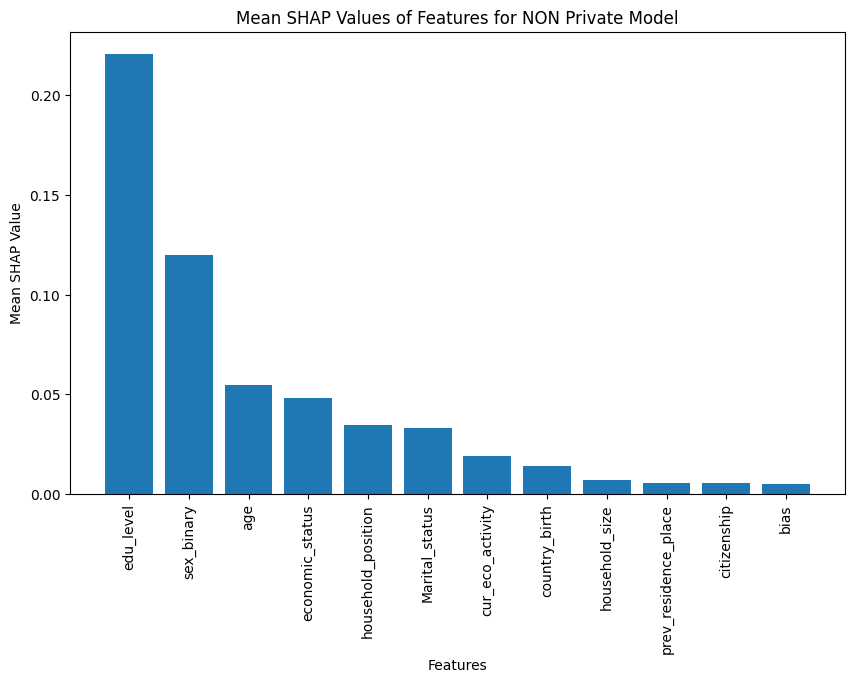

In [134]:
plot_base_explainer_shap_values(
    loaded_data=loaded_data_NO_DP_bb,
    explainer_privacy_levels=explainer_privacy_levels,
    X_test=X_test,
    feature_names=feature_names,
    title="Mean SHAP Values of Features for NON Private Model",
    explainer_name="explanations_NO_DP",
)

In [135]:
top_k_non_private_bb = [
    "edu_level",
    "age",
    "sex_binary",
    "economic_status",
]

12
12


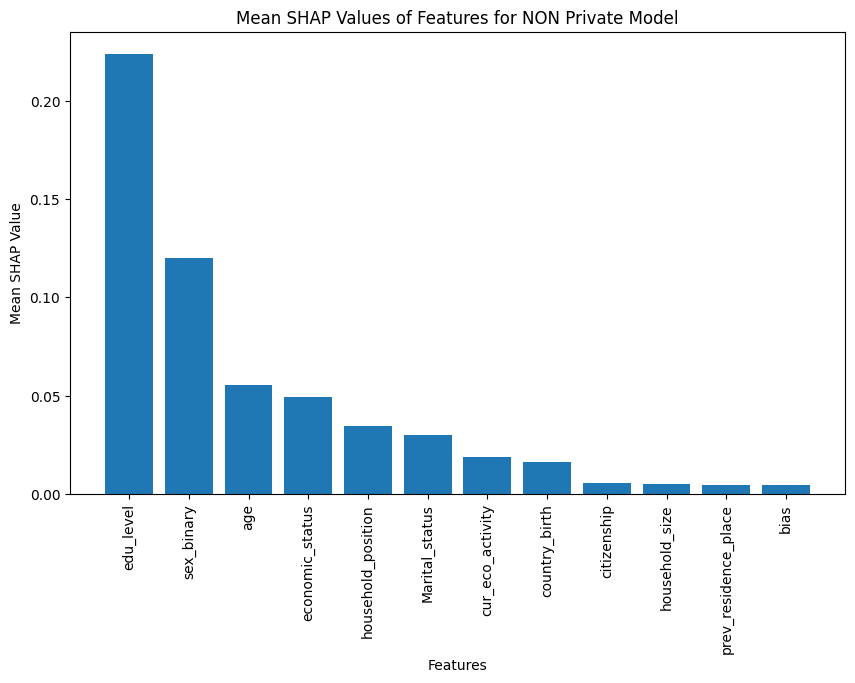

In [136]:
plot_base_explainer_shap_values(
    loaded_data=loaded_data_NO_DP_bb,
    explainer_privacy_levels=explainer_privacy_levels,
    X_test=X_test,
    feature_names=feature_names,
    title="Mean SHAP Values of Features for NON Private Model",
    explainer_name="explanations_NO_DP_centralised",
)

In [137]:
# plot_base_explainer_shap_values_comparison(
#     loaded_data=loaded_data_NO_DP_bb,
#     explainer_names=["explanations_NO_DP", "explanations_NO_DP_centralised"],
#     X_test=X_test,
#     feature_names=[
#         "Edu Level",
#         "Sex",
#         "Age",
#         "Ec. Status",
#         "House Pos.",
#         "Mar. Status",
#         "Eco act.",
#         "Country Birth",
#         "House. Size",
#         "Prev. Res.",
#         "Citizenship",
#     ],
#     title="Mean Shapley Value: FL vs Centralized Explainer",
#     file_name="comparison_dutch",
# )

In [138]:
def create_dictionaries_metrics(
    explainer_privacy_levels, metrics, current_metric, compute_std=True
):
    mean = {}
    std = {}
    if compute_std:
        for privacy_level in explainer_privacy_levels:
            mean["Epsilon " + privacy_level] = np.mean(
                metrics[current_metric + privacy_level]
            )
            std["Epsilon " + privacy_level] = np.std(
                metrics[current_metric + privacy_level]
            )
        return mean, std
    else:
        for privacy_level in explainer_privacy_levels:
            mean["Epsilon " + privacy_level] = metrics[current_metric + privacy_level]

        return mean

In [139]:
metrics_NO_DP_bb = compute_metrics(
    X_test,
    loaded_data_NO_DP_bb,
    explainer_privacy_levels,
    top_k_non_private_bb,
    feature_names,
)

In [140]:
metrics_NO_DP_bb["signed_rank_agreement_NO_DP"]

array([1., 1., 1., ..., 1., 1., 1.])

In [141]:
results_mean, result_std = create_dictionaries_metrics(
    explainer_privacy_levels, metrics_NO_DP_bb, "L2_"
)

In [142]:
explainer_privacy_levels

['NO_DP', 'NO_DP_centralised']

In [143]:
results_mean

{'Epsilon NO_DP': 0.0, 'Epsilon NO_DP_centralised': 0.025534725}

In [144]:
cosine_mean, cosine_std = create_dictionaries_metrics(
    explainer_privacy_levels, metrics_NO_DP_bb, "cosine_"
)

In [145]:
cosine_mean

{'Epsilon NO_DP': 1.0, 'Epsilon NO_DP_centralised': 0.9938048}

In [146]:
spearman_mean, spearman_std = create_dictionaries_metrics(
    explainer_privacy_levels, metrics_NO_DP_bb, "spearman_"
)

In [147]:
spearman_mean

{'Epsilon NO_DP': 1.0, 'Epsilon NO_DP_centralised': 0.9700933149762888}

In [148]:
kendaltau_mean, kendaltau_std = create_dictionaries_metrics(
    explainer_privacy_levels, metrics_NO_DP_bb, "kendall_"
)

In [149]:
kendaltau_mean

{'Epsilon NO_DP': 1.0, 'Epsilon NO_DP_centralised': 0.953622966702361}

In [150]:
feature_agreement_mean, feature_agreement_std = create_dictionaries_metrics(
    explainer_privacy_levels,
    metrics_NO_DP_bb,
    "feature_agreement_",
)

rank_agreement_mean, rank_agreement_std = create_dictionaries_metrics(
    explainer_privacy_levels, metrics_NO_DP_bb, "rank_agreement_"
)

sign_agreement_mean, sign_agreement_std = create_dictionaries_metrics(
    explainer_privacy_levels, metrics_NO_DP_bb, "sign_agreement_"
)

signed_rank_agreement_mean, signed_rank_agreement_std = create_dictionaries_metrics(
    explainer_privacy_levels,
    metrics_NO_DP_bb,
    "signed_rank_agreement_",
)

pairwise_rank_agreement_t_mean, pairwise_rank_agreement_t_std = (
    create_dictionaries_metrics(
        explainer_privacy_levels,
        metrics_NO_DP_bb,
        "pairwise_rank_agreement_",
    )
)

rank_corr_mean, rank_corr_std = create_dictionaries_metrics(
    explainer_privacy_levels, metrics_NO_DP_bb, "rank_corr_"
)

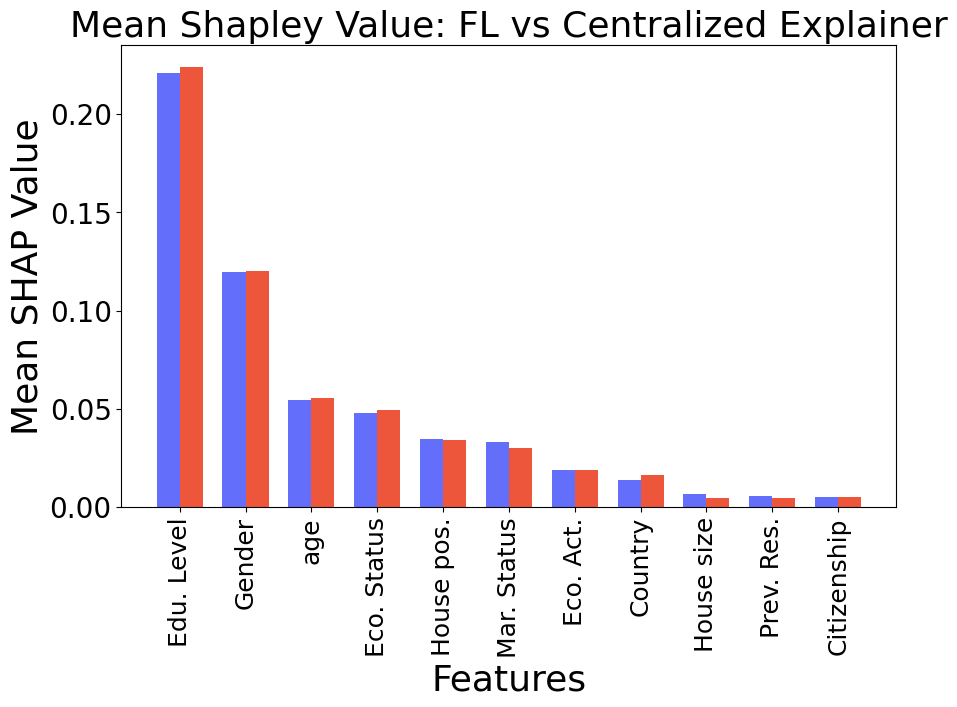

In [169]:
feature_names = [
    "age",
    "House pos.",
    "House size",
    "Prev. Res.",
    "Citizenship",
    "Country",
    "Edu. Level",
    "Eco. Status",
    "Eco. Act.",
    "Mar. Status",
    "Gender",
    "bias",
]

plot_base_explainer_shap_values_comparison(
    loaded_data=loaded_data_NO_DP_bb,
    explainer_names=["explanations_NO_DP", "explanations_NO_DP_centralised"],
    X_test=X_test,
    feature_names=feature_names,
    title="Mean Shapley Value: FL vs Centralized Explainer",
    file_name="comparison_income_new",
)

In [152]:
# create a dataframe with the results of the metrics
import pandas as pd

results = pd.DataFrame(
    {
        "L2": f"{results_mean['Epsilon NO_DP_centralised']:.2f}$\pm${result_std['Epsilon NO_DP_centralised']:.2f}",
        "Cosine Similarity": f"{cosine_mean['Epsilon NO_DP_centralised']:.2f}$\pm${cosine_std['Epsilon NO_DP_centralised']:.2f}",
        # "Spearman": f"{spearman_mean['Epsilon NO_DP_centralised']:.2f}$\pm${spearman_std['Epsilon NO_DP_centralised']:.2f}",
        # "Kendall Tau": f"{kendaltau_mean['Epsilon NO_DP_centralised']:.2f}$\pm${kendaltau_std['Epsilon NO_DP_centralised']:.2f}",
        "Feature Agreement": f"{feature_agreement_mean['Epsilon NO_DP_centralised']:.2f}$\pm${feature_agreement_std['Epsilon NO_DP_centralised']:.2f}",
        # "Rank Agreement": f"{rank_agreement_mean['Epsilon NO_DP_centralised']:.2f}$\pm${rank_agreement_std['Epsilon NO_DP_centralised']:.2f}",
        "Sign Agreement": f"{sign_agreement_mean['Epsilon NO_DP_centralised']:.2f}$\pm${sign_agreement_std['Epsilon NO_DP_centralised']:.2f}",
        # "Signed Rank Agreement": f"{signed_rank_agreement_mean['Epsilon NO_DP_centralised']:.2f}$\pm${signed_rank_agreement_std['Epsilon NO_DP_centralised']:.2f}",
        # "Pairwise Rank Agreement": f"{pairwise_rank_agreement_t_mean['Epsilon NO_DP_centralised']:.2f}$\pm${pairwise_rank_agreement_t_std['Epsilon NO_DP_centralised']:.2f}",
        "Rank Correlation": f"{rank_corr_mean['Epsilon NO_DP_centralised']:.2f}$\pm${rank_corr_std['Epsilon NO_DP_centralised']:.2f}",
    },
    index=["Metrics"],
)

results.head()

# convert to latex table
print(results.to_latex())

\begin{tabular}{llllll}
\toprule
 & L2 & Cosine Similarity & Feature Agreement & Sign Agreement & Rank Correlation \\
\midrule
Metrics & 0.03$\pm$0.02 & 0.99$\pm$0.01 & 0.87$\pm$0.13 & 0.87$\pm$0.13 & 0.84$\pm$0.11 \\
\bottomrule
\end{tabular}



# Faithfulness

In [153]:
from scipy.stats import sem

In [154]:
def plot_faithfulness_std_dev(
    faithfulness_no_dp,
    faithfulness_no_dp_centralised,
):
    mean_no_dp = np.mean(faithfulness_no_dp)
    std_no_dp = sem(faithfulness_no_dp)

    mean_no_dp_centralised = np.mean(faithfulness_no_dp)
    std_no_dp_centralised = sem(faithfulness_no_dp)

    results_mean = {
        "No DP": [mean_no_dp],
        "No DP Centralised": [mean_no_dp_centralised],
    }

    results_std = {
        "No DP": [std_no_dp],
        "No DP Centralised": [std_no_dp_centralised],
    }

    # Extracting the means and standard errors

    labels = list(results_mean.keys())
    means = [results_mean[label][0] for label in labels]
    errors = [results_std[label][0] for label in labels]

    # Plotting
    plt.figure(figsize=(8, 6))

    # Use different markers for each point
    markers = ["o", "s", "^", "D", "P", "X", "H", "v", "<", ">", "d", "p", "*", "h"]

    for i, label in enumerate(labels):
        plt.errorbar(
            i,
            means[i],
            yerr=errors[i],
            fmt=markers[i],
            label=label,
            capsize=5,
            markersize=10,
        )

    # Customizing the plot
    plt.xticks(range(len(labels)), labels, fontsize=12)
    plt.ylabel("Mean Faithfulness", fontsize=14)
    plt.title(
        "Mean Faithfulness with Standard Deviation for Different Epsilon Values",
        fontsize=16,
    )
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()

    # orientation x axis labels
    plt.xticks(rotation=90)

    plt.show()

In [155]:
# print(loaded_data_NO_DP_bb["faithfulness_NO_DP"])
# print(loaded_data_NO_DP_bb["faithfulness_NO_DP_centralised"])

In [156]:
differences = []
for a, b in zip(
    loaded_data_NO_DP_bb["faithfulness_NO_DP"],
    loaded_data_NO_DP_bb["faithfulness_NO_DP_centralised"],
):
    differences.append(np.abs(a - b))
print(np.mean(differences))
print(np.std(differences))

0.02323851605672235
0.029444175647444865


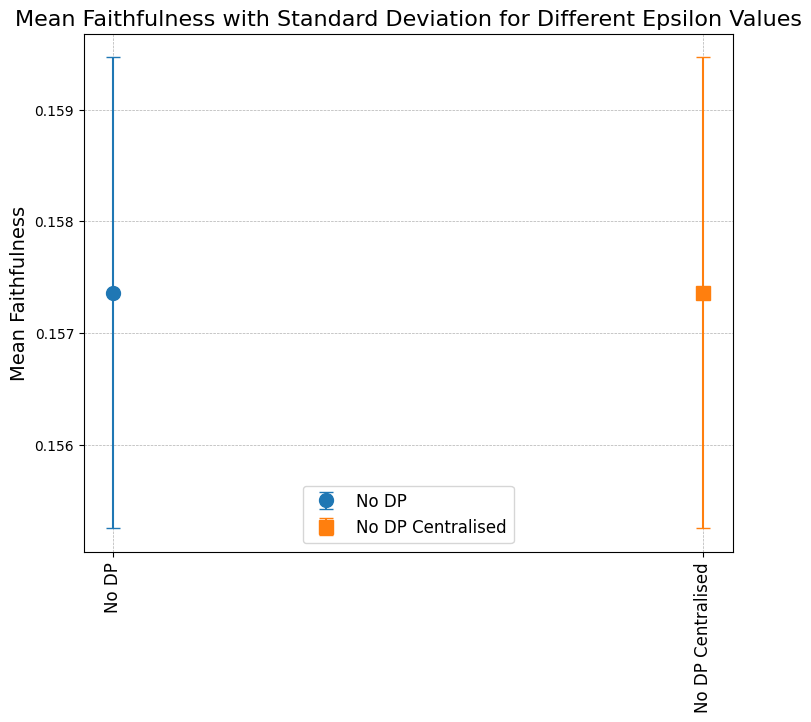

In [157]:
plot_faithfulness_std_dev(
    faithfulness_no_dp=loaded_data_NO_DP_bb["faithfulness_NO_DP"],
    faithfulness_no_dp_centralised=loaded_data_NO_DP_bb[
        "faithfulness_NO_DP_centralised"
    ],
)

In [158]:
def compute_differences():  # Difference of the faithfulness
    differences = []
    for fl, centralised in zip(
        loaded_data_NO_DP_bb["faithfulness_NO_DP"],
        loaded_data_NO_DP_bb["faithfulness_NO_DP_centralised"],
    ):
        differences.append(fl - centralised)

    mean_diff = np.mean(differences)
    std_diff = sem(differences)

    print(f"Mean difference: {mean_diff}")
    print(f"Standard error of the mean: {std_diff}")

# Income

In [52]:
test_nodes = ["25", "23", "19", "11", "4", "45", "26", "9", "29", "16"]
explainer_privacy_levels = ["NO_DP", "NO_DP_centralised"]
bb_privacy_levels = ["NO_DP"]
# feature_names = ["Age", "Education", "Mar. Stat.", "Relationship",DIS,ESP,CIT,MIG,MIL,ANC,"Origin",DEAR,DEYE,DREM,"Gender","Race"]
feature_names = [
    "Age",
    "Work Class",
    "Education",
    "Mar. Status",
    "Occupation",
    "Place of Birth",
    "Relationship",
    "Work Hours/week",
    "Gender",
    "Race",
    "bias",
]

In [53]:
loaded_data_NO_DP_bb = load_data(
    private_model=False,
    private_surrogate=False,
    explainer_privacy_levels=explainer_privacy_levels,
    base_path="../../../artifacts/income_federated_comparison/",
    model_name="bb",
    surrogate_name="surrogate",
    explainer_name="explainer",
    device="cuda",
    num_features=11,
)

Loading saved model
Loading saved surrogate model
Loading saved explainer model
Loading saved explainer model


In [54]:
train_nodes = [str(i) for i in range(0, 50) if str(i) not in test_nodes]
train_nodes

['0',
 '1',
 '2',
 '3',
 '5',
 '6',
 '7',
 '8',
 '10',
 '12',
 '13',
 '14',
 '15',
 '17',
 '18',
 '20',
 '21',
 '22',
 '24',
 '27',
 '28',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '46',
 '47',
 '48',
 '49']

In [55]:
len(test_nodes)

10

In [56]:
assert len(train_nodes) + len(test_nodes) == 50

In [57]:
X_test, y_test = prepare_data_FL(
    test_clients=test_nodes,
    batch_size=10000,
    dataset_name="income",
    num_workers=0,
    fed_dir="/raid/lcorbucci/folktables/income_data_reduced/federated",
    device="cuda",
    num_features=11,
    seed=42,
    surrogate=loaded_data_NO_DP_bb["surrogate"],
    train_clients=train_nodes,
)

In [58]:
# predictions with BB model

loaded_data_NO_DP_bb["model_predictions"] = get_model_predictions(
    model=loaded_data_NO_DP_bb["model"], X_test=X_test
)

In [59]:
#  use this matrix of ones to
ones = torch.ones(1, 11, dtype=torch.float32, device="cuda")

surrogate_output = []
for x in X_test:
    output = loaded_data_NO_DP_bb["surrogate"](
        torch.tensor(x).to("cuda"), ones[: len(x)].to("cuda")
    )
    surrogate_output.append(output.cpu().detach().numpy())

surrogate_output = np.array(surrogate_output)

In [60]:
surrogate_outputs = [np.argmax(item, axis=1)[0] for item in surrogate_output]

model_predictions = [item.item() for item in loaded_data_NO_DP_bb["model_predictions"]]

In [61]:
# compare surrogate_output with model_predictions and compute the model fidelity

model_fidelity = np.sum(
    np.array(surrogate_outputs) == np.array(model_predictions)
) / len(model_predictions)

print(f"Model fidelity: {model_fidelity}")

Model fidelity: 0.9332306973456417


In [62]:
# Compute the base value

base_value = np.mean(X_test)
base_value

0.57004446

In [63]:
get_explanations(
    model_predictions=loaded_data_NO_DP_bb["model_predictions"],
    X_test=X_test,
    loaded_data=loaded_data_NO_DP_bb,
    base_value=base_value,
    base_path="../../../artifacts/income_federated_comparison/",
    explainer_privacy_levels=explainer_privacy_levels,
)

In [64]:
loaded_data_NO_DP_bb["explanations_NO_DP"][1]

array([0.00176478, 0.00351752, 0.07465685, 0.00113562, 0.03074608,
       0.00235933, 0.00815863, 0.00399305, 0.00100205, 0.00192628,
       0.00050889], dtype=float32)

In [65]:
loaded_data_NO_DP_bb["explanations_NO_DP_centralised"][1]

array([-6.4229660e-02, -2.0365901e-03,  1.2827024e-01,  7.9178154e-02,
       -7.5012729e-02,  1.1924632e-02,  3.6575079e-02,  1.0379229e-02,
        3.8058691e-02,  9.1456072e-03,  1.9252300e-05], dtype=float32)

In [66]:
len(X_test)

166933

11
11


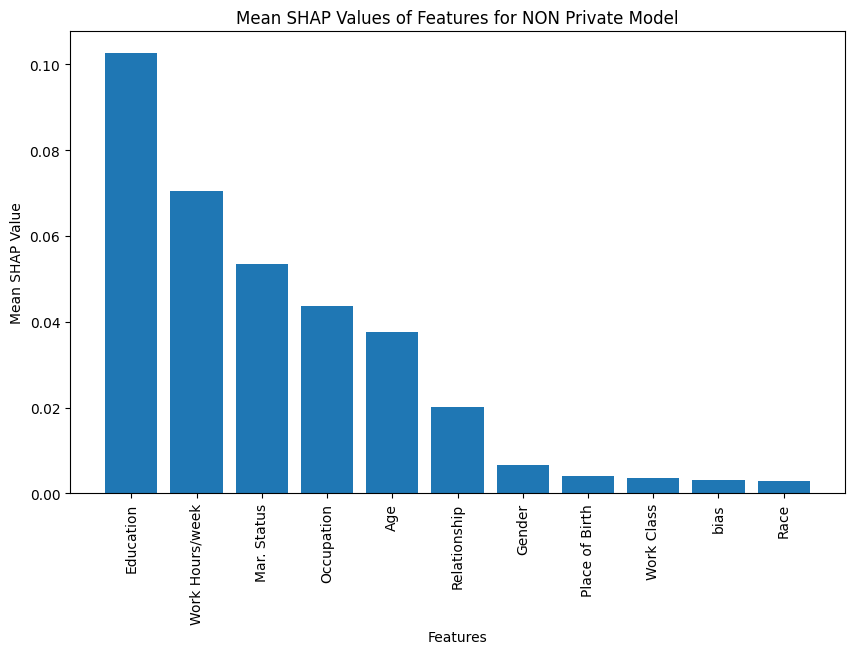

In [67]:
plot_base_explainer_shap_values(
    loaded_data=loaded_data_NO_DP_bb,
    explainer_privacy_levels=explainer_privacy_levels,
    X_test=X_test,
    feature_names=feature_names,
    title="Mean SHAP Values of Features for NON Private Model",
    explainer_name="explanations_NO_DP",
)

In [68]:
top_k_non_private_bb = [
    "Mar. Status",
    "Education",
    "Occupation",
]

11
11


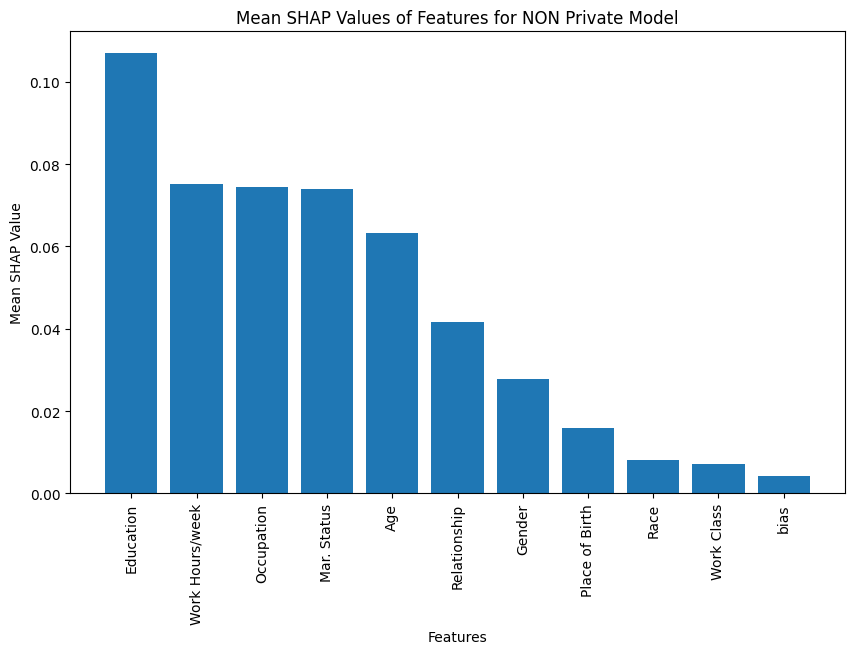

In [69]:
plot_base_explainer_shap_values(
    loaded_data=loaded_data_NO_DP_bb,
    explainer_privacy_levels=explainer_privacy_levels,
    X_test=X_test,
    feature_names=feature_names,
    title="Mean SHAP Values of Features for NON Private Model",
    explainer_name="explanations_NO_DP_centralised",
)

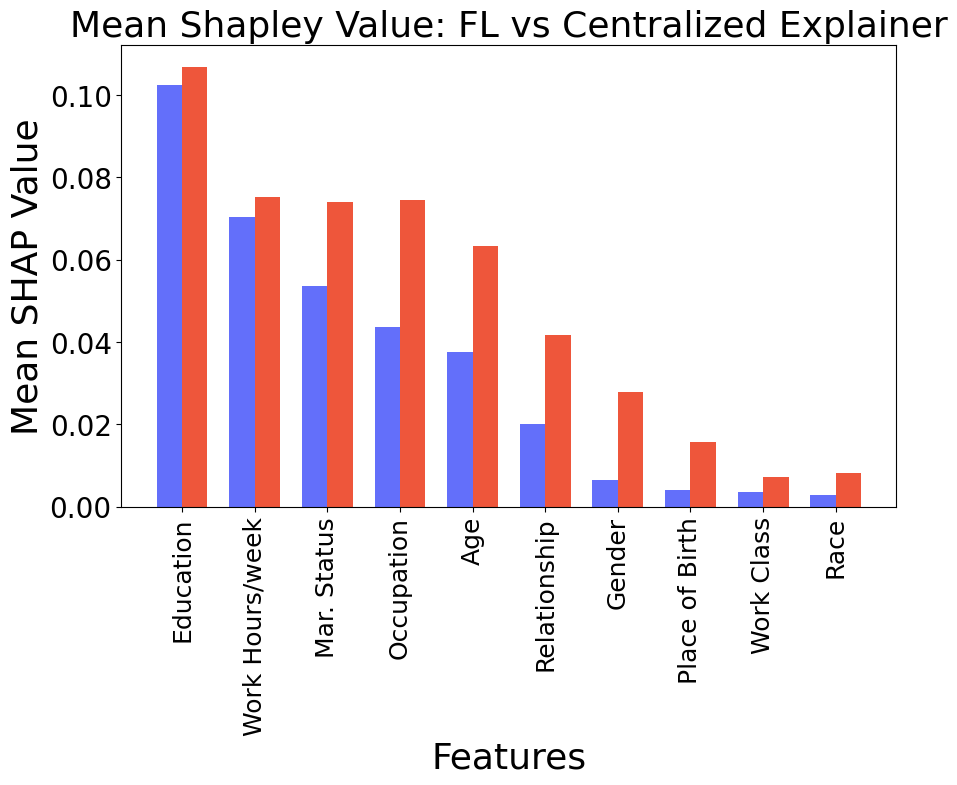

In [70]:
plot_base_explainer_shap_values_comparison(
    loaded_data=loaded_data_NO_DP_bb,
    explainer_names=["explanations_NO_DP", "explanations_NO_DP_centralised"],
    X_test=X_test,
    feature_names=feature_names,
    title="Mean Shapley Value: FL vs Centralized Explainer",
    file_name="comparison_income_new",
)

In [71]:
def create_dictionaries_metrics(
    explainer_privacy_levels, metrics, current_metric, compute_std=True
):
    mean = {}
    std = {}
    if compute_std:
        for privacy_level in explainer_privacy_levels:
            mean["Epsilon " + privacy_level] = np.mean(
                metrics[current_metric + privacy_level]
            )
            std["Epsilon " + privacy_level] = np.std(
                metrics[current_metric + privacy_level]
            )
        return mean, std
    else:
        for privacy_level in explainer_privacy_levels:
            mean["Epsilon " + privacy_level] = metrics[current_metric + privacy_level]

        return mean

In [72]:
metrics_NO_DP_bb = compute_metrics(
    X_test,
    loaded_data_NO_DP_bb,
    explainer_privacy_levels,
    top_k_non_private_bb,
    feature_names,
)

In [73]:
metrics_NO_DP_bb["signed_rank_agreement_NO_DP"]

array([1., 1., 1., ..., 1., 1., 1.])

In [74]:
results_mean, result_std = create_dictionaries_metrics(
    explainer_privacy_levels, metrics_NO_DP_bb, "L2_"
)

In [75]:
explainer_privacy_levels

['NO_DP', 'NO_DP_centralised']

In [76]:
results_mean

{'Epsilon NO_DP': 0.0, 'Epsilon NO_DP_centralised': 0.0881727}

In [77]:
cosine_mean, cosine_std = create_dictionaries_metrics(
    explainer_privacy_levels, metrics_NO_DP_bb, "cosine_"
)

In [78]:
cosine_mean

{'Epsilon NO_DP': 1.0, 'Epsilon NO_DP_centralised': 0.80510855}

In [79]:
spearman_mean, spearman_std = create_dictionaries_metrics(
    explainer_privacy_levels, metrics_NO_DP_bb, "spearman_"
)

In [80]:
spearman_mean

{'Epsilon NO_DP': 1.0, 'Epsilon NO_DP_centralised': 0.6608938915612851}

In [81]:
kendaltau_mean, kendaltau_std = create_dictionaries_metrics(
    explainer_privacy_levels, metrics_NO_DP_bb, "kendall_"
)

In [82]:
kendaltau_mean

{'Epsilon NO_DP': 1.0, 'Epsilon NO_DP_centralised': 0.5884256957382104}

In [83]:
feature_agreement_mean, feature_agreement_std = create_dictionaries_metrics(
    explainer_privacy_levels,
    metrics_NO_DP_bb,
    "feature_agreement_",
)

rank_agreement_mean, rank_agreement_std = create_dictionaries_metrics(
    explainer_privacy_levels, metrics_NO_DP_bb, "rank_agreement_"
)

sign_agreement_mean, sign_agreement_std = create_dictionaries_metrics(
    explainer_privacy_levels, metrics_NO_DP_bb, "sign_agreement_"
)

signed_rank_agreement_mean, signed_rank_agreement_std = create_dictionaries_metrics(
    explainer_privacy_levels,
    metrics_NO_DP_bb,
    "signed_rank_agreement_",
)

pairwise_rank_agreement_t_mean, pairwise_rank_agreement_t_std = (
    create_dictionaries_metrics(
        explainer_privacy_levels,
        metrics_NO_DP_bb,
        "pairwise_rank_agreement_",
    )
)

rank_corr_mean, rank_corr_std = create_dictionaries_metrics(
    explainer_privacy_levels, metrics_NO_DP_bb, "rank_corr_"
)

In [84]:
# create a dataframe with the results of the metrics
import pandas as pd

results = pd.DataFrame(
    {
        "L2": f"{results_mean['Epsilon NO_DP_centralised']:.2f}$\pm${result_std['Epsilon NO_DP_centralised']:.2f}",
        "Cosine Similarity": f"{cosine_mean['Epsilon NO_DP_centralised']:.2f}$\pm${cosine_std['Epsilon NO_DP_centralised']:.2f}",
        # "Spearman": f"{spearman_mean['Epsilon NO_DP_centralised']:.2f}$\pm${spearman_std['Epsilon NO_DP_centralised']:.2f}",
        # "Kendall Tau": f"{kendaltau_mean['Epsilon NO_DP_centralised']:.2f}$\pm${kendaltau_std['Epsilon NO_DP_centralised']:.2f}",
        "Feature Agreement": f"{feature_agreement_mean['Epsilon NO_DP_centralised']:.2f}$\pm${feature_agreement_std['Epsilon NO_DP_centralised']:.2f}",
        # "Rank Agreement": f"{rank_agreement_mean['Epsilon NO_DP_centralised']:.2f}$\pm${rank_agreement_std['Epsilon NO_DP_centralised']:.2f}",
        "Sign Agreement": f"{sign_agreement_mean['Epsilon NO_DP_centralised']:.2f}$\pm${sign_agreement_std['Epsilon NO_DP_centralised']:.2f}",
        # "Signed Rank Agreement": f"{signed_rank_agreement_mean['Epsilon NO_DP_centralised']:.2f}$\pm${signed_rank_agreement_std['Epsilon NO_DP_centralised']:.2f}",
        # "Pairwise Rank Agreement": f"{pairwise_rank_agreement_t_mean['Epsilon NO_DP_centralised']:.2f}$\pm${pairwise_rank_agreement_t_std['Epsilon NO_DP_centralised']:.2f}",
        "Rank Correlation": f"{rank_corr_mean['Epsilon NO_DP_centralised']:.2f}$\pm${rank_corr_std['Epsilon NO_DP_centralised']:.2f}",
    },
    index=["Metrics"],
)

results.head()

# convert to latex table
print(results.to_latex())

\begin{tabular}{llllll}
\toprule
 & L2 & Cosine Similarity & Feature Agreement & Sign Agreement & Rank Correlation \\
\midrule
Metrics & 0.09$\pm$0.05 & 0.81$\pm$0.22 & 0.77$\pm$0.14 & 0.70$\pm$0.17 & 0.70$\pm$0.17 \\
\bottomrule
\end{tabular}



# Faithfulness

In [85]:
from scipy.stats import sem

In [86]:
def plot_faithfulness_std_dev(
    faithfulness_no_dp,
    faithfulness_no_dp_centralised,
):
    mean_no_dp = np.mean(faithfulness_no_dp)
    std_no_dp = sem(faithfulness_no_dp)

    mean_no_dp_centralised = np.mean(faithfulness_no_dp)
    std_no_dp_centralised = sem(faithfulness_no_dp)

    results_mean = {
        "No DP": [mean_no_dp],
        "No DP Centralised": [mean_no_dp_centralised],
    }

    results_std = {
        "No DP": [std_no_dp],
        "No DP Centralised": [std_no_dp_centralised],
    }

    # Extracting the means and standard errors

    labels = list(results_mean.keys())
    means = [results_mean[label][0] for label in labels]
    errors = [results_std[label][0] for label in labels]

    # Plotting
    plt.figure(figsize=(8, 6))

    # Use different markers for each point
    markers = ["o", "s", "^", "D", "P", "X", "H", "v", "<", ">", "d", "p", "*", "h"]

    for i, label in enumerate(labels):
        plt.errorbar(
            i,
            means[i],
            yerr=errors[i],
            fmt=markers[i],
            label=label,
            capsize=5,
            markersize=10,
        )

    # Customizing the plot
    plt.xticks(range(len(labels)), labels, fontsize=12)
    plt.ylabel("Mean Faithfulness", fontsize=14)
    plt.title(
        "Mean Faithfulness with Standard Deviation for Different Epsilon Values",
        fontsize=16,
    )
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()

    # orientation x axis labels
    plt.xticks(rotation=90)

    plt.show()

In [87]:
print(np.mean(loaded_data_NO_DP_bb["faithfulness_NO_DP"]))
print(np.mean(loaded_data_NO_DP_bb["faithfulness_NO_DP_centralised"]))

0.21032525236630967
0.29562114447888427


In [88]:
differences = []
for a, b in zip(
    loaded_data_NO_DP_bb["faithfulness_NO_DP"],
    loaded_data_NO_DP_bb["faithfulness_NO_DP_centralised"],
):
    differences.append(np.abs(a - b))
print(np.mean(differences))
print(np.std(differences))

0.13149716085178548
0.1013993973653885


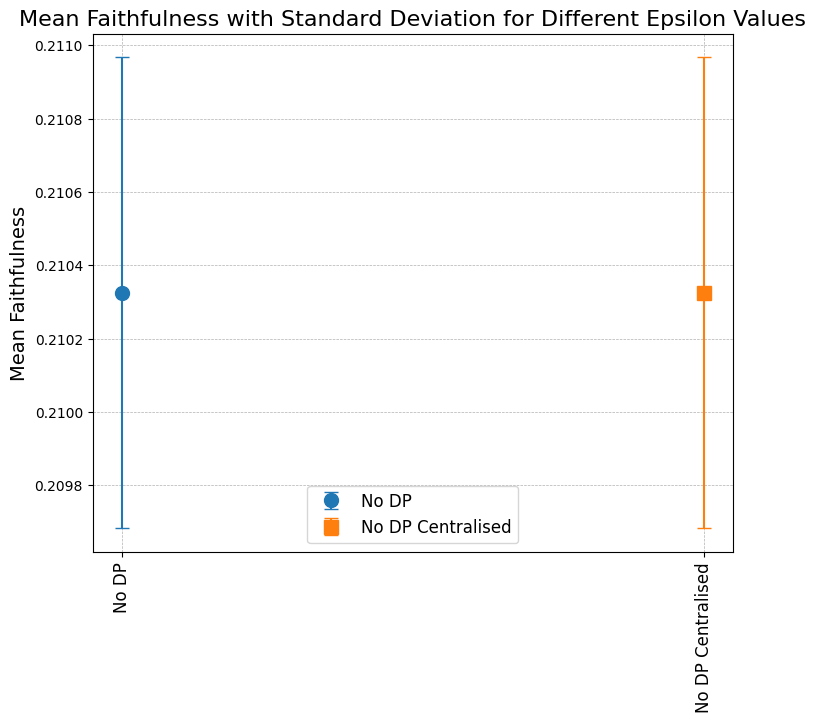

In [89]:
plot_faithfulness_std_dev(
    faithfulness_no_dp=loaded_data_NO_DP_bb["faithfulness_NO_DP"],
    faithfulness_no_dp_centralised=loaded_data_NO_DP_bb[
        "faithfulness_NO_DP_centralised"
    ],
)

In [90]:
def compute_differences():  # Difference of the faithfulness
    differences = []
    for fl, centralised in zip(
        loaded_data_NO_DP_bb["faithfulness_NO_DP"],
        loaded_data_NO_DP_bb["faithfulness_NO_DP_centralised"],
    ):
        differences.append(fl - centralised)

    mean_diff = np.mean(differences)
    std_diff = sem(differences)

    print(f"Mean difference: {mean_diff}")
    print(f"Standard error of the mean: {std_diff}")

# Employment

In [91]:
test_nodes = ["25", "23", "19", "11", "4", "45", "26", "9", "29", "16"]
explainer_privacy_levels = ["NO_DP", "NO_DP_centralised"]
bb_privacy_levels = ["NO_DP"]
feature_names = [
    "Age",
    "Education",
    "Mar. Stat.",
    "Relationship",
    "DIS",
    "Parent Empl.",
    "Citizenship",
    "Mobility",
    "Military",
    "Ancestry",
    "Origin",
    "Hear. Diff.",
    "Vis. Diff.",
    "Cogn. Diff.",
    "Gender",
    "Race",
    "bias",
]

In [92]:
len(feature_names)

17

In [93]:
loaded_data_NO_DP_bb = load_data(
    private_model=False,
    private_surrogate=False,
    explainer_privacy_levels=explainer_privacy_levels,
    base_path="../../../artifacts/employment_reduced_comparison/",
    model_name="bb",
    surrogate_name="surrogate",
    explainer_name="explainer",
    device="cuda",
    num_features=17,
)

Loading saved model
Loading saved surrogate model
Loading saved explainer model
Loading saved explainer model


In [94]:
train_nodes = [str(i) for i in range(0, 50) if str(i) not in test_nodes]
train_nodes

['0',
 '1',
 '2',
 '3',
 '5',
 '6',
 '7',
 '8',
 '10',
 '12',
 '13',
 '14',
 '15',
 '17',
 '18',
 '20',
 '21',
 '22',
 '24',
 '27',
 '28',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '46',
 '47',
 '48',
 '49']

In [95]:
len(test_nodes)

10

In [96]:
assert len(train_nodes) + len(test_nodes) == 50

In [97]:
X_test, y_test = prepare_data_FL(
    test_clients=test_nodes,
    batch_size=10000,
    dataset_name="employment",
    num_workers=0,
    fed_dir="/raid/lcorbucci/folktables/employment_data_reduced/federated",
    device="cuda",
    num_features=18,
    seed=42,
    surrogate=loaded_data_NO_DP_bb["surrogate"],
    train_clients=train_nodes,
)

In [98]:
# predictions with BB model

loaded_data_NO_DP_bb["model_predictions"] = get_model_predictions(
    model=loaded_data_NO_DP_bb["model"], X_test=X_test
)

In [99]:
#  use this matrix of ones to
ones = torch.ones(1, 17, dtype=torch.float32, device="cuda")

surrogate_output = []
for x in X_test:
    output = loaded_data_NO_DP_bb["surrogate"](
        torch.tensor(x).to("cuda"), ones[: len(x)].to("cuda")
    )
    surrogate_output.append(output.cpu().detach().numpy())

surrogate_output = np.array(surrogate_output)

In [100]:
surrogate_outputs = [np.argmax(item, axis=1)[0] for item in surrogate_output]

model_predictions = [item.item() for item in loaded_data_NO_DP_bb["model_predictions"]]

In [101]:
# compare surrogate_output with model_predictions and compute the model fidelity

model_fidelity = np.sum(
    np.array(surrogate_outputs) == np.array(model_predictions)
) / len(model_predictions)

print(f"Model fidelity: {model_fidelity}")

Model fidelity: 0.970685


In [102]:
# Compute the base value

base_value = np.mean(X_test)
base_value

0.91995627

In [103]:
get_explanations(
    model_predictions=loaded_data_NO_DP_bb["model_predictions"],
    X_test=X_test,
    loaded_data=loaded_data_NO_DP_bb,
    base_value=base_value,
    base_path="../../../artifacts/employment_reduced_comparison/",
    explainer_privacy_levels=explainer_privacy_levels,
)

In [104]:
loaded_data_NO_DP_bb["explanations_NO_DP"][1]

array([ 0.10261458, -0.0039737 ,  0.00406638, -0.02666615,  0.0272679 ,
       -0.02293155,  0.00377932,  0.01522952, -0.01418571,  0.01694906,
       -0.00834125, -0.00720108, -0.0083281 ,  0.00229903,  0.04681186,
       -0.0012615 ,  0.00660926], dtype=float32)

In [105]:
loaded_data_NO_DP_bb["explanations_NO_DP_centralised"][1]

array([ 0.26780498, -0.09754559,  0.05051604, -0.04663176, -0.04410284,
       -0.02486675, -0.00305829, -0.00348534, -0.00635752,  0.0134584 ,
       -0.00651892,  0.00297581,  0.00494162, -0.01697078,  0.05275106,
        0.00472667,  0.00603324], dtype=float32)

In [106]:
len(X_test)

200000

17
17


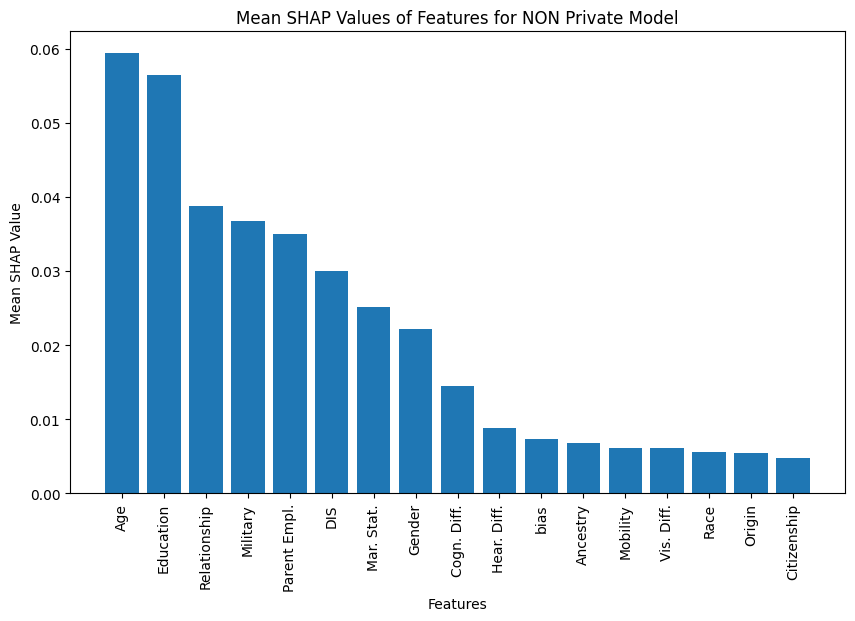

In [107]:
plot_base_explainer_shap_values(
    loaded_data=loaded_data_NO_DP_bb,
    explainer_privacy_levels=explainer_privacy_levels,
    X_test=X_test,
    feature_names=feature_names,
    title="Mean SHAP Values of Features for NON Private Model",
    explainer_name="explanations_NO_DP",
)

In [108]:
top_k_non_private_bb = [
    "Age",
    "Education",
    "Relationship",
    "Military",
    "Parent Empl.",
    "DIS",
]

17
17


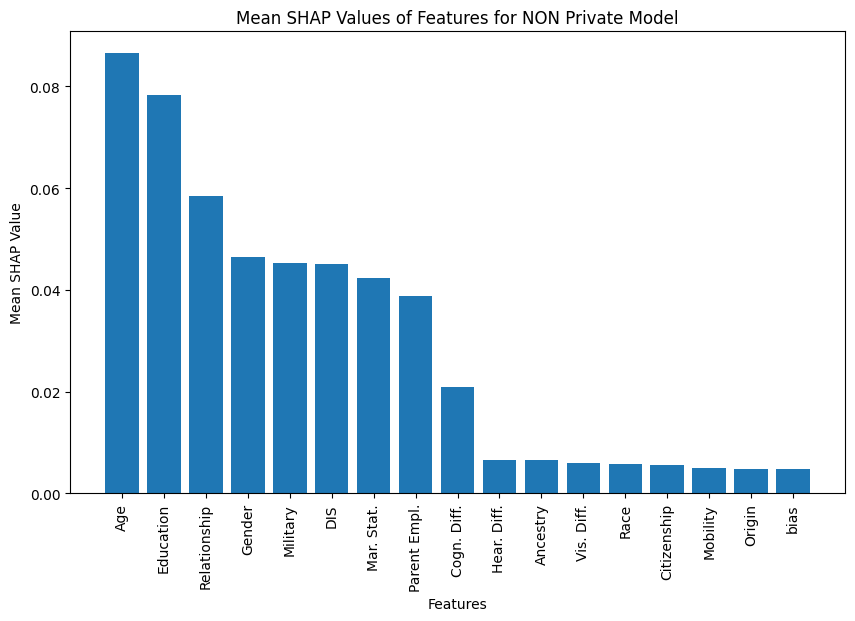

In [109]:
plot_base_explainer_shap_values(
    loaded_data=loaded_data_NO_DP_bb,
    explainer_privacy_levels=explainer_privacy_levels,
    X_test=X_test,
    feature_names=feature_names,
    title="Mean SHAP Values of Features for NON Private Model",
    explainer_name="explanations_NO_DP_centralised",
)

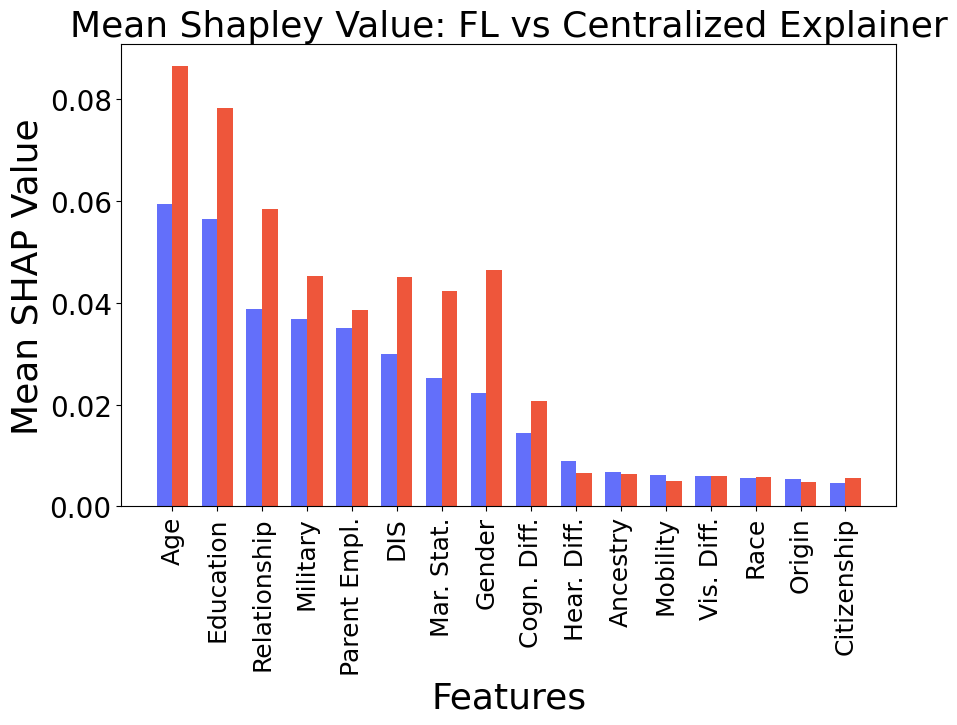

In [110]:
plot_base_explainer_shap_values_comparison(
    loaded_data=loaded_data_NO_DP_bb,
    explainer_names=["explanations_NO_DP", "explanations_NO_DP_centralised"],
    X_test=X_test,
    feature_names=feature_names,
    title="Mean Shapley Value: FL vs Centralized Explainer",
    file_name="comparison_employment",
)

In [111]:
def create_dictionaries_metrics(
    explainer_privacy_levels, metrics, current_metric, compute_std=True
):
    mean = {}
    std = {}
    if compute_std:
        for privacy_level in explainer_privacy_levels:
            mean["Epsilon " + privacy_level] = np.mean(
                metrics[current_metric + privacy_level]
            )
            std["Epsilon " + privacy_level] = np.std(
                metrics[current_metric + privacy_level]
            )
        return mean, std
    else:
        for privacy_level in explainer_privacy_levels:
            mean["Epsilon " + privacy_level] = metrics[current_metric + privacy_level]

        return mean

In [112]:
metrics_NO_DP_bb = compute_metrics(
    X_test,
    loaded_data_NO_DP_bb,
    explainer_privacy_levels,
    top_k_non_private_bb,
    feature_names,
)

In [113]:
metrics_NO_DP_bb["signed_rank_agreement_NO_DP"]

array([1., 1., 1., ..., 1., 1., 1.])

In [114]:
results_mean, result_std = create_dictionaries_metrics(
    explainer_privacy_levels, metrics_NO_DP_bb, "L2_"
)

In [115]:
explainer_privacy_levels

['NO_DP', 'NO_DP_centralised']

In [116]:
results_mean

{'Epsilon NO_DP': 0.0, 'Epsilon NO_DP_centralised': 0.100764014}

In [117]:
cosine_mean, cosine_std = create_dictionaries_metrics(
    explainer_privacy_levels, metrics_NO_DP_bb, "cosine_"
)

In [118]:
cosine_mean

{'Epsilon NO_DP': 1.0, 'Epsilon NO_DP_centralised': 0.80202174}

In [119]:
spearman_mean, spearman_std = create_dictionaries_metrics(
    explainer_privacy_levels, metrics_NO_DP_bb, "spearman_"
)

In [120]:
spearman_mean

{'Epsilon NO_DP': 1.0, 'Epsilon NO_DP_centralised': 0.5548808571428572}

In [121]:
kendaltau_mean, kendaltau_std = create_dictionaries_metrics(
    explainer_privacy_levels, metrics_NO_DP_bb, "kendall_"
)

In [122]:
kendaltau_mean

{'Epsilon NO_DP': 0.9999999999999999,
 'Epsilon NO_DP_centralised': 0.45209800000000006}

In [123]:
feature_agreement_mean, feature_agreement_std = create_dictionaries_metrics(
    explainer_privacy_levels,
    metrics_NO_DP_bb,
    "feature_agreement_",
)

rank_agreement_mean, rank_agreement_std = create_dictionaries_metrics(
    explainer_privacy_levels, metrics_NO_DP_bb, "rank_agreement_"
)

sign_agreement_mean, sign_agreement_std = create_dictionaries_metrics(
    explainer_privacy_levels, metrics_NO_DP_bb, "sign_agreement_"
)

signed_rank_agreement_mean, signed_rank_agreement_std = create_dictionaries_metrics(
    explainer_privacy_levels,
    metrics_NO_DP_bb,
    "signed_rank_agreement_",
)

pairwise_rank_agreement_t_mean, pairwise_rank_agreement_t_std = (
    create_dictionaries_metrics(
        explainer_privacy_levels,
        metrics_NO_DP_bb,
        "pairwise_rank_agreement_",
    )
)

rank_corr_mean, rank_corr_std = create_dictionaries_metrics(
    explainer_privacy_levels, metrics_NO_DP_bb, "rank_corr_"
)

In [124]:
# create a dataframe with the results of the metrics
import pandas as pd

results = pd.DataFrame(
    {
        "L2": f"{results_mean['Epsilon NO_DP_centralised']:.2f}$\pm${result_std['Epsilon NO_DP_centralised']:.2f}",
        "Cosine Similarity": f"{cosine_mean['Epsilon NO_DP_centralised']:.2f}$\pm${cosine_std['Epsilon NO_DP_centralised']:.2f}",
        # "Spearman": f"{spearman_mean['Epsilon NO_DP_centralised']:.2f}$\pm${spearman_std['Epsilon NO_DP_centralised']:.2f}",
        # "Kendall Tau": f"{kendaltau_mean['Epsilon NO_DP_centralised']:.2f}$\pm${kendaltau_std['Epsilon NO_DP_centralised']:.2f}",
        "Feature Agreement": f"{feature_agreement_mean['Epsilon NO_DP_centralised']:.2f}$\pm${feature_agreement_std['Epsilon NO_DP_centralised']:.2f}",
        # "Rank Agreement": f"{rank_agreement_mean['Epsilon NO_DP_centralised']:.2f}$\pm${rank_agreement_std['Epsilon NO_DP_centralised']:.2f}",
        "Sign Agreement": f"{sign_agreement_mean['Epsilon NO_DP_centralised']:.2f}$\pm${sign_agreement_std['Epsilon NO_DP_centralised']:.2f}",
        # "Signed Rank Agreement": f"{signed_rank_agreement_mean['Epsilon NO_DP_centralised']:.2f}$\pm${signed_rank_agreement_std['Epsilon NO_DP_centralised']:.2f}",
        # "Pairwise Rank Agreement": f"{pairwise_rank_agreement_t_mean['Epsilon NO_DP_centralised']:.2f}$\pm${pairwise_rank_agreement_t_std['Epsilon NO_DP_centralised']:.2f}",
        "Rank Correlation": f"{rank_corr_mean['Epsilon NO_DP_centralised']:.2f}$\pm${rank_corr_std['Epsilon NO_DP_centralised']:.2f}",
    },
    index=["Metrics"],
)

results.head()

# convert to latex table
print(results.to_latex())

\begin{tabular}{llllll}
\toprule
 & L2 & Cosine Similarity & Feature Agreement & Sign Agreement & Rank Correlation \\
\midrule
Metrics & 0.10$\pm$0.05 & 0.80$\pm$0.19 & 0.66$\pm$0.16 & 0.64$\pm$0.17 & 0.65$\pm$0.16 \\
\bottomrule
\end{tabular}



# Faithfulness

In [125]:
from scipy.stats import sem

In [126]:
def plot_faithfulness_std_dev(
    faithfulness_no_dp,
    faithfulness_no_dp_centralised,
):
    mean_no_dp = np.mean(faithfulness_no_dp)
    std_no_dp = sem(faithfulness_no_dp)

    mean_no_dp_centralised = np.mean(faithfulness_no_dp)
    std_no_dp_centralised = sem(faithfulness_no_dp)

    results_mean = {
        "No DP": [mean_no_dp],
        "No DP Centralised": [mean_no_dp_centralised],
    }

    results_std = {
        "No DP": [std_no_dp],
        "No DP Centralised": [std_no_dp_centralised],
    }

    # Extracting the means and standard errors

    labels = list(results_mean.keys())
    means = [results_mean[label][0] for label in labels]
    errors = [results_std[label][0] for label in labels]

    # Plotting
    plt.figure(figsize=(8, 6))

    # Use different markers for each point
    markers = ["o", "s", "^", "D", "P", "X", "H", "v", "<", ">", "d", "p", "*", "h"]

    for i, label in enumerate(labels):
        plt.errorbar(
            i,
            means[i],
            yerr=errors[i],
            fmt=markers[i],
            label=label,
            capsize=5,
            markersize=10,
        )

    # Customizing the plot
    plt.xticks(range(len(labels)), labels, fontsize=12)
    plt.ylabel("Mean Faithfulness", fontsize=14)
    plt.title(
        "Mean Faithfulness with Standard Deviation for Different Epsilon Values",
        fontsize=16,
    )
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()

    # orientation x axis labels
    plt.xticks(rotation=90)

    plt.show()

In [127]:
print(np.mean(loaded_data_NO_DP_bb["faithfulness_NO_DP"]))
print(np.mean(loaded_data_NO_DP_bb["faithfulness_NO_DP_centralised"]))

-0.001267538470387262
0.16030983261547802


In [128]:
differences = []
for a, b in zip(
    loaded_data_NO_DP_bb["faithfulness_NO_DP"],
    loaded_data_NO_DP_bb["faithfulness_NO_DP_centralised"],
):
    differences.append(np.abs(a - b))
print(np.mean(differences))
print(np.std(differences))

0.21856476375371167
0.1890599837631905


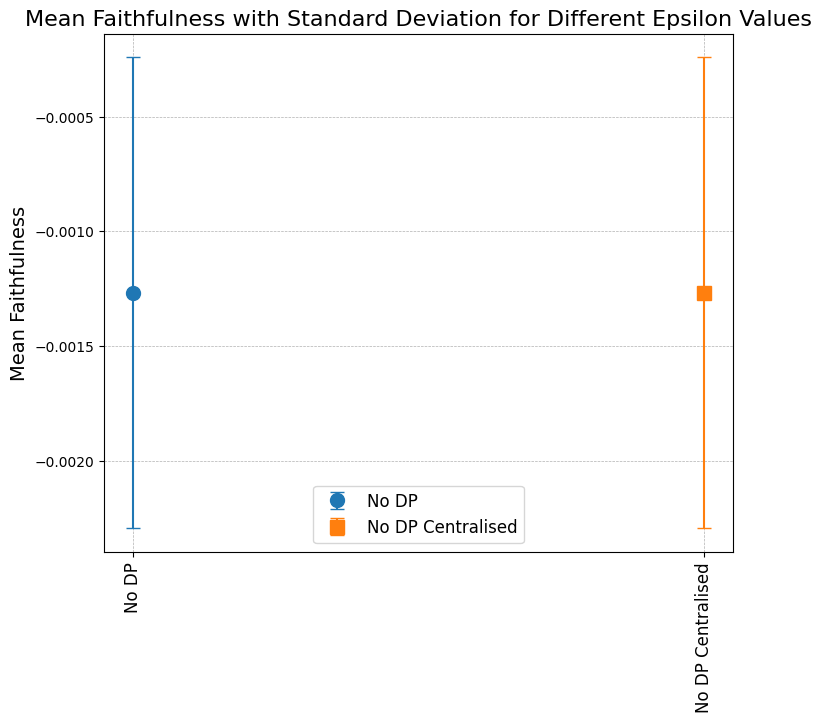

In [129]:
plot_faithfulness_std_dev(
    faithfulness_no_dp=loaded_data_NO_DP_bb["faithfulness_NO_DP"],
    faithfulness_no_dp_centralised=loaded_data_NO_DP_bb[
        "faithfulness_NO_DP_centralised"
    ],
)

In [130]:
def compute_differences():  # Difference of the faithfulness
    differences = []
    for fl, centralised in zip(
        loaded_data_NO_DP_bb["faithfulness_NO_DP"],
        loaded_data_NO_DP_bb["faithfulness_NO_DP_centralised"],
    ):
        differences.append(fl - centralised)

    mean_diff = np.mean(differences)
    std_diff = sem(differences)

    print(f"Mean difference: {mean_diff}")
    print(f"Standard error of the mean: {std_diff}")